In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler

from torchvision import transforms, datasets

from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.utils import class_weight

from PIL import Image
from torch.optim.lr_scheduler import StepLR
import random


In [2]:
seed = 42
torch.manual_seed(seed)           
random.seed(seed)                  
np.random.seed(seed)               
torch.cuda.manual_seed(seed)       
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False

# **Data Preprocessing**

In [3]:
train_data_path = '/kaggle/input/flame-ds/Training/Training'
test_data_path = '/kaggle/input/flame-ds/Test/Test'

In [4]:
from collections import Counter

# Load dataset
train_dataset = datasets.ImageFolder(root=train_data_path)

# Print class-to-index mapping
print("Class-to-Index Mapping:", train_dataset.class_to_idx)

# Get counts of each label
label_counts = Counter([sample[1] for sample in train_dataset.samples])

# Print counts for each label
print("Label Counts:")
for label, count in label_counts.items():
    class_name = list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(label)]
    print(f"{class_name}: {count} images")


Class-to-Index Mapping: {'Fire': 0, 'No_Fire': 1}
Label Counts:
Fire: 25018 images
No_Fire: 14357 images


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.5),  # Vertical flip
    transforms.RandomRotation(degrees=10),  # Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),  # Gaussian noise
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Load datasets (without transformations initially)
train_dataset = datasets.ImageFolder(root=train_data_path)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)

# Oversampling to balance classes
indices = list(range(len(train_dataset)))
targets = [sample[1] for sample in train_dataset.samples]  # Labels for each sample

ros = RandomOverSampler(sampling_strategy=0.8, random_state=42)
resampled_indices, resampled_targets = ros.fit_resample(np.array(indices).reshape(-1, 1), targets)
resampled_indices = resampled_indices.flatten()

# Create oversampled subset
train_subset = Subset(train_dataset, resampled_indices)
train_subset.dataset.transform = train_transforms  # Apply augmentation to the subset

# Stratified train-validation split (80-20)
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(
    range(len(train_subset)),
    test_size=0.2,
    stratify=resampled_targets,
    random_state=42
)

train_split = Subset(train_subset, train_indices)
val_split = Subset(train_subset, val_indices)

# Apply test transforms to validation subset
val_split.dataset.transform = test_transforms

# Data loaders
train_loader = DataLoader(train_split, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_split, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print dataset sizes
print(f"Training Set Size: {len(train_split)} images")
print(f"Validation Set Size: {len(val_split)} images")
print(f"Testing Set Size: {len(test_dataset)} images")

Training Set Size: 36025 images
Validation Set Size: 9007 images
Testing Set Size: 8617 images


In [7]:
from collections import Counter

# Directly count labels for train_split and val_split using resampled_targets
def subset_label_counts(subset_indices, resampled_targets):
    # Map the subset indices to resampled_targets
    labels = [resampled_targets[i] for i in subset_indices]
    return Counter(labels)

# Count labels for train and validation splits
train_label_counts = subset_label_counts(train_indices, resampled_targets)
val_label_counts = subset_label_counts(val_indices, resampled_targets)

print("\nTraining Label Distribution:")
for label, count in sorted(train_label_counts.items()):
    print(f"Class {label}: {count} samples")

print("\nValidation Label Distribution:")
for label, count in sorted(val_label_counts.items()):
    print(f"Class {label}: {count} samples")



Training Label Distribution:
Class 0: 20014 samples
Class 1: 16011 samples

Validation Label Distribution:
Class 0: 5004 samples
Class 1: 4003 samples


# **Load Model**

In [8]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load a pretrained EfficientNet-B0 model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)  # 2 for binary classification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 182MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **Train**

In [10]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True

In [11]:
import torch
import time
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, device, patience=5, num_epochs=50):
    early_stopping = EarlyStopping(patience=patience)
    model.to(device)

    # Lists to track metrics
    train_losses, val_losses, train_accuracies, val_accuracies, learning_rates = [], [], [], [], []
    gpu_usage, fps = [], []

    for epoch in range(num_epochs):
        # Fetch and print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)  # Track learning rate
        print(f"\nEpoch {epoch+1}/{num_epochs}, Learning Rate: {current_lr:.6f}")

        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # GPU memory tracking
        start_time = time.time()
        for images, labels in tqdm(train_loader, desc="Training Batches"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Check for logits attribute (e.g., in DeiT models)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            # Compute loss and backpropagate
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Monitor GPU memory usage
        gpu_allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)  # Convert to GB
        gpu_reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)   # Convert to GB
        gpu_usage.append((gpu_allocated, gpu_reserved))

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)  # Track training loss
        train_accuracies.append(epoch_acc)  # Track training accuracy

        # Measure FPS
        end_time = time.time()
        fps_epoch = len(train_loader.dataset) / (end_time - start_time)
        fps.append(fps_epoch)

        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%, FPS: {fps_epoch:.2f}")
        print(f"GPU Memory Allocated: {gpu_allocated:.2f} GB, GPU Memory Reserved: {gpu_reserved:.2f} GB")

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation Batches"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # Check for logits attribute
                if hasattr(outputs, 'logits'):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100. * correct / total
        val_losses.append(val_epoch_loss)  # Track validation loss
        val_accuracies.append(val_epoch_acc)  # Track validation accuracy
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%")

        # Step the LR scheduler
        scheduler.step(val_epoch_loss)

        # Early Stopping Check
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            print("Stopping early due to convergence.")
            break

    # Plot Results
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies, learning_rates, fps, gpu_usage)


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, learning_rates, fps, gpu_usage):
    # Learning Rate
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid()
    plt.show()

    # Training vs Validation Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # FPS
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(fps) + 1), fps, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Frames Per Second (FPS)")
    plt.title("Training Speed (FPS)")
    plt.grid()
    plt.show()

    # GPU Usage
    allocated, reserved = zip(*gpu_usage)
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(allocated)), allocated, label="GPU Allocated (GB)")
    plt.plot(range(len(reserved)), reserved, label="GPU Reserved (GB)")
    plt.xlabel("Batches")
    plt.ylabel("GPU Memory (GB)")
    plt.title("GPU Memory Usage")
    plt.legend()
    plt.grid()
    plt.show()



Epoch 1/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [04:05<00:00,  4.60it/s]


Training Loss: 0.0261, Training Accuracy: 99.22%, FPS: 147.03
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:57<00:00,  4.93it/s]


Validation Loss: 0.0055, Validation Accuracy: 99.88%

Epoch 2/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:38<00:00,  5.15it/s]


Training Loss: 0.0063, Training Accuracy: 99.80%, FPS: 164.80
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:47<00:00,  5.92it/s]


Validation Loss: 0.0024, Validation Accuracy: 99.93%

Epoch 3/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:39<00:00,  5.14it/s]


Training Loss: 0.0034, Training Accuracy: 99.90%, FPS: 164.44
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:47<00:00,  5.98it/s]


Validation Loss: 0.0033, Validation Accuracy: 99.86%

Epoch 4/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:41<00:00,  5.08it/s]


Training Loss: 0.0035, Training Accuracy: 99.88%, FPS: 162.48
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:48<00:00,  5.77it/s]


Validation Loss: 0.0036, Validation Accuracy: 99.94%

Epoch 5/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:43<00:00,  5.03it/s]


Training Loss: 0.0040, Training Accuracy: 99.90%, FPS: 160.89
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:49<00:00,  5.68it/s]


Validation Loss: 0.0025, Validation Accuracy: 99.92%

Epoch 6/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:43<00:00,  5.04it/s]


Training Loss: 0.0031, Training Accuracy: 99.91%, FPS: 161.31
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:48<00:00,  5.86it/s]


Validation Loss: 0.0035, Validation Accuracy: 99.94%

Epoch 7/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:43<00:00,  5.04it/s]


Training Loss: 0.0034, Training Accuracy: 99.89%, FPS: 161.40
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:49<00:00,  5.65it/s]


Validation Loss: 0.0020, Validation Accuracy: 99.96%

Epoch 8/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:47<00:00,  4.94it/s]


Training Loss: 0.0031, Training Accuracy: 99.90%, FPS: 158.17
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:50<00:00,  5.59it/s]


Validation Loss: 0.0043, Validation Accuracy: 99.89%

Epoch 9/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:45<00:00,  4.99it/s]


Training Loss: 0.0024, Training Accuracy: 99.92%, FPS: 159.50
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:48<00:00,  5.84it/s]


Validation Loss: 0.0022, Validation Accuracy: 99.96%

Epoch 10/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:47<00:00,  4.95it/s]


Training Loss: 0.0030, Training Accuracy: 99.93%, FPS: 158.34
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:48<00:00,  5.80it/s]


Validation Loss: 0.0058, Validation Accuracy: 99.86%

Epoch 11/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:48<00:00,  4.93it/s]


Training Loss: 0.0026, Training Accuracy: 99.92%, FPS: 157.83
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:49<00:00,  5.70it/s]


Validation Loss: 0.0034, Validation Accuracy: 99.88%

Epoch 12/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 1126/1126 [03:47<00:00,  4.95it/s]


Training Loss: 0.0022, Training Accuracy: 99.94%, FPS: 158.34
GPU Memory Allocated: 0.09 GB, GPU Memory Reserved: 3.16 GB


Validation Batches: 100%|██████████| 282/282 [00:51<00:00,  5.51it/s]


Validation Loss: 0.0065, Validation Accuracy: 99.84%
Early stopping triggered!
Stopping early due to convergence.


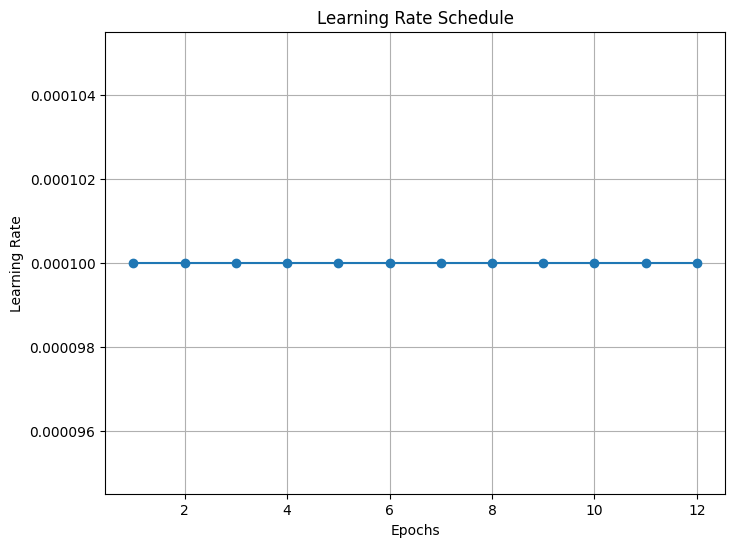

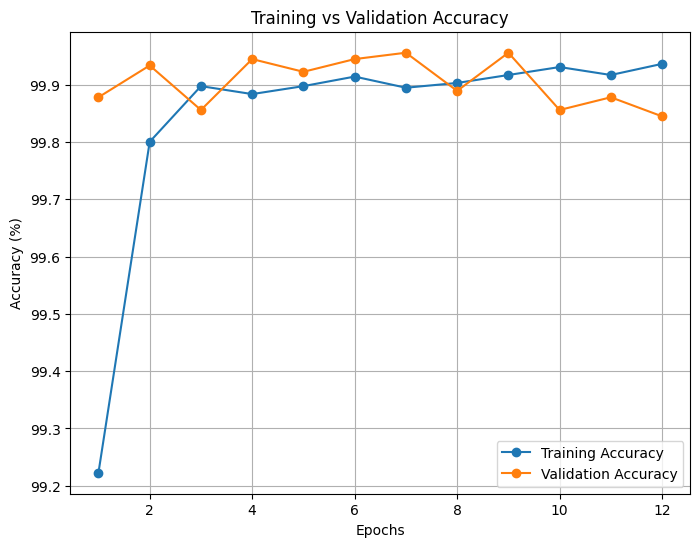

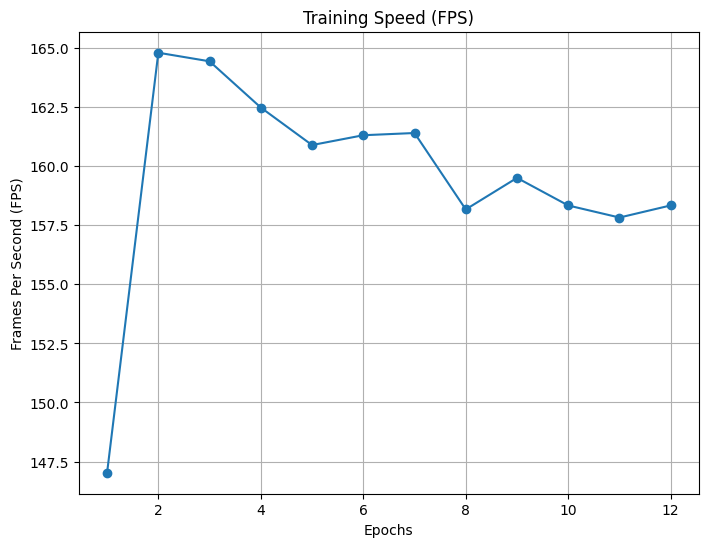

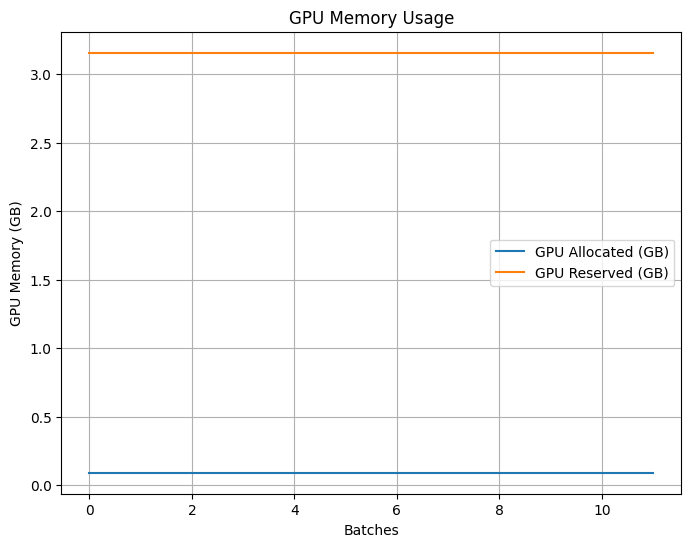

In [12]:
results = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    patience=5,  
    num_epochs=50
)


# **Evaluation**

In [13]:
def evaluate_model_with_metrics(model, loader, binary_classification=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            
            # Get model outputs
            outputs = model(images)
            
            # For DeiT models, extract logits
            if hasattr(outputs, 'logits'):  
                outputs = outputs.logits
            
            # Get predicted classes
            _, predicted = outputs.max(1)

            # Accumulate metrics
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Probabilities for ROC AUC
            if binary_classification:
                probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probabilities)

    # Accuracy
    accuracy = 100. * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels),
                yticklabels=np.unique(all_labels), cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1-Score
    precision = precision_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    recall = recall_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    f1 = f1_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # AUC-ROC and ROC Curve (for binary classification)
    if binary_classification:
        all_probs = np.array(all_probs)
        if len(np.unique(all_labels)) == 2: 
            fpr, tpr, _ = roc_curve(all_labels, all_probs)
            auc_score = auc(fpr, tpr)
            print(f"AUC-ROC: {auc_score:.4f}")

            # Plot ROC Curve
            plt.figure()
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
            plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.grid()
            plt.show()
        else:
            print("AUC-ROC is not supported for multi-class tasks without modification.")

Accuracy on test set: 80.72%
Confusion Matrix:
 [[3860 1277]
 [ 384 3096]]


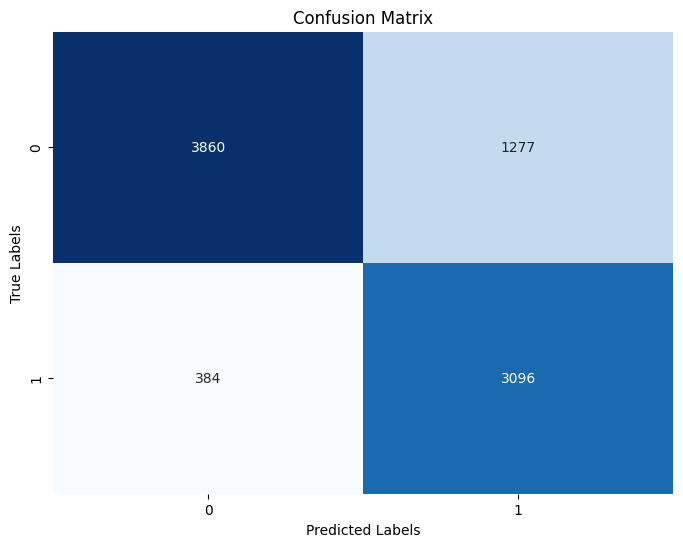

Precision: 0.7080
Recall: 0.8897
F1-Score: 0.7885
AUC-ROC: 0.9184


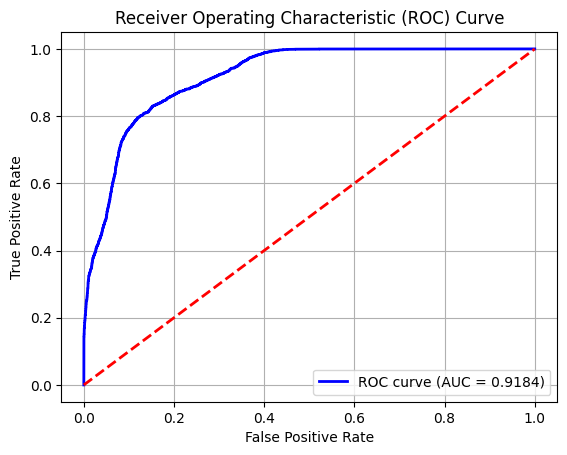

In [14]:
evaluate_model_with_metrics(model, test_loader, binary_classification=True)

# **Save Model**

In [15]:
# File paths to save models
resnet18_path_50epochs = '/kaggle/working/model.pth'

torch.save(model.state_dict(), resnet18_path_50epochs)

print("Models saved successfully to /kaggle/working/")

Models saved successfully to /kaggle/working/
